# RKDE (Robust Kernel Density Estimation)

## Generating  the data set

In [11]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = (20,10)
# Define the number of points
n_samples = 200

mu1, sigma1 = 0,1 # mean and variance
mu2, sigma2 = 15,1

x1 = np.random.normal(mu1,np.sqrt(sigma1),n_samples)
x2 = np.random.normal(mu2,np.sqrt(sigma2),n_samples) 

def pdf(loc,variance,observation):
    '''Giving the Probability Density Function

    Parameters
    ----------
        loc (Int): Mean of the distribution ; where the peak of the bell exists
        variance(Int) : variance
        sample (Array) : the distribution

    Returns
    -------
        ndrray: Gaussian distribution
    '''
    # A normal continuous random variable.
    s1 = 1/(np.sqrt(2*np.pi*variance))
    s2 = np.exp(-(np.square(observation - loc)/(2*variance)))
    return s1 * s2 

# Adding outliers
outliers1 = np.random.uniform(5.5,6,10)
outliers2 = np.random.uniform(9,10,10)
""" outliers2 = np.random.uniform(5,5.1,25)
outliers = list(outliers1) + list(outliers2)
x1 = np.append(x1,outliers[:21])
x2 = np.append(x2,outliers[21:])
 """
X = np.array(list(x1) + list(x2))
outliers = np.append(outliers1, outliers2)
X = np.append(X, outliers)
#np.random.shuffle(X)
print("Dataset Shape: ", X.shape)
n_samples_final = X.shape[0]

Dataset Shape:  (420,)


### Visualize the training data

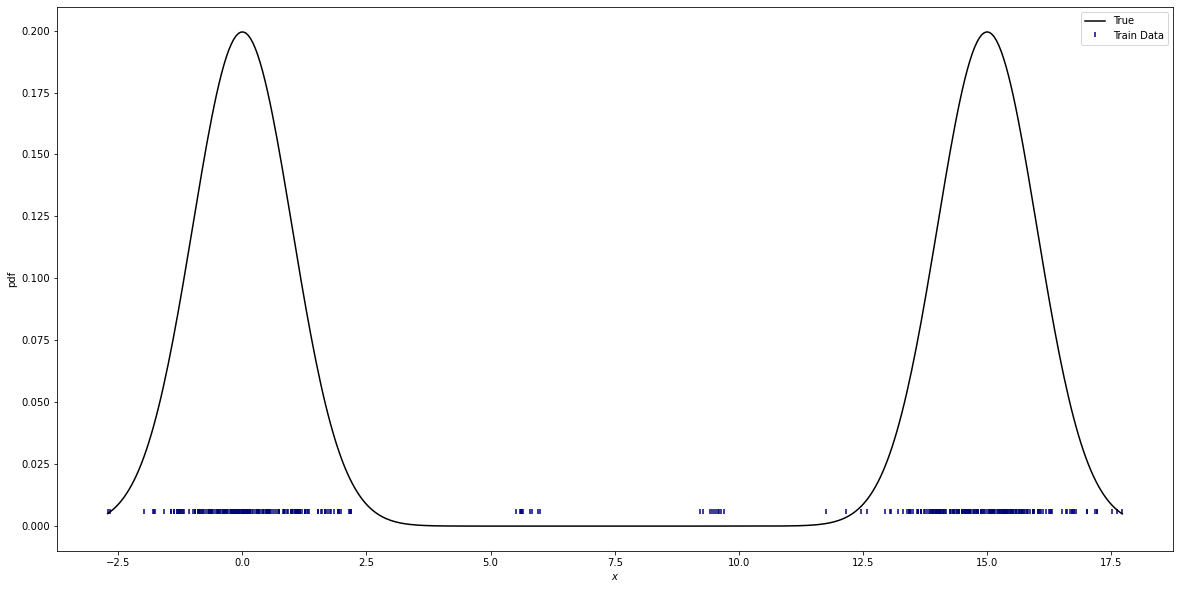

In [12]:
bins = np.linspace(np.min(X),np.max(X),n_samples_final)

plt.xlabel("$x$")
plt.ylabel("pdf")

plt.scatter(X,[.005] * len(X), color='navy', s=30, marker=2, label="Train Data")
#plt.scatter(outliers,[.005] * len(outliers), color='red', s=20, marker='x', label="Outliers")

plt.plot(bins, .5 * pdf(mu1,sigma1,bins)+ .5 * pdf(mu2,sigma2,bins), color='black', label="True")
#plt.plot(bins, pdf(mu2,sigma2,bins), color='black')

plt.legend()
plt.show()

## Applying KDE (Kernel Density Estimation)

In [13]:
def kernel_function(obs,givenData,h,d=1):
    """ Kernel Function

    Parameters
    ----------
        obs (Int): Observation data
        h (Int): variance of the distribution
        d (Int, optional): dimension
        givenData (Int): Gaussian value
    
    Returns
    -------
        Int: kernel value   
    """
    result = (h**2 * 2*np.pi)**(-d/2) *np.exp((-1/2)* ((obs - givenData)/h)**2)
    return result

def kernel_density_function(obs_data,givenData,h=.1,d=1):
    '''Kernel Density Function
    Parameters
    ----------
        obs_data (Array): Observation data  
        h (Int): windows size
        d (Int, optional): dimension
        givenData (Array): Gaussian values

    Returns
    -------
      Array: new data after applying kdf
    '''
    final_result = []
    # Size of the gaussian data
    size = len(givenData)
    for obs in obs_data:
        k_result = 0
        for g in givenData:
            k_result +=  (1/size) * kernel_function(obs,g,h)
        final_result.append(k_result)
    return final_result

def kernel_density_function_for_rkde(obs_data,givenData,weights, h=.1,d=1):
    '''Kernel Density Function
    Parameters
    ----------
        obs_data (Array): Observation data  
        h (Int): windows size

        d (Int, optional): dimension
        givenData (Array): Gaussian values

    Returns
    -------
      Array: new data after applying kdf
    '''
    final_result = []
    #weights = np.array(weights)
    #weights = np.array(weights)
    # Size of the gaussian data
    size = len(givenData)
    for obs in obs_data:
        k_result = 0
        for index,g in enumerate(givenData):
            #print(index)
            k_result +=  weights[index] * kernel_function(obs,g,h)
        final_result.append(k_result)
    return final_result 



windows = (1/np.sqrt(n_samples_final)*20)
X_kde = kernel_density_function(bins,X,windows)
"""X_kde2 = kernel_density_function(bins,(x2))

##### PLOTING ##########
#plt.figure(figsize=(10,7))
plt.xlabel("$x$")
plt.ylabel("pdf")

plt.scatter(X,[.005] * len(X), color='navy', s=30, marker=2, label="Train Data")
plt.scatter(outliers,[.005] * len(outliers), color='red', s=20, marker='x', label="Outliers")

plt.plot(bins, .5 * pdf(mu1,sigma1,bins)+ .5 * pdf(mu2,sigma2,bins), color='black', label="True")
#plt.plot(bins, pdf(mu2,sigma2,bins), color='black')

plt.plot(bins, X_kde, color='blue', label="KDE", dashes=[6,2])
#plt.plot(bins, X_kde2, color='blue', dashes=[6,2])

plt.legend()
plt.show()"""

'X_kde2 = kernel_density_function(bins,(x2))\n\n##### PLOTING ##########\n#plt.figure(figsize=(10,7))\nplt.xlabel("$x$")\nplt.ylabel("pdf")\n\nplt.scatter(X,[.005] * len(X), color=\'navy\', s=30, marker=2, label="Train Data")\nplt.scatter(outliers,[.005] * len(outliers), color=\'red\', s=20, marker=\'x\', label="Outliers")\n\nplt.plot(bins, .5 * pdf(mu1,sigma1,bins)+ .5 * pdf(mu2,sigma2,bins), color=\'black\', label="True")\n#plt.plot(bins, pdf(mu2,sigma2,bins), color=\'black\')\n\nplt.plot(bins, X_kde, color=\'blue\', label="KDE", dashes=[6,2])\n#plt.plot(bins, X_kde2, color=\'blue\', dashes=[6,2])\n\nplt.legend()\nplt.show()'

## Applying RKDE (Robust Kernel Density Estimation)

#### Step1 : Initialize wi(0) . Let k = 1.

In [14]:
from collections import Counter

def search_weight(X):
    count_weights = Counter(X)
    total = sum(count_weights.values())
    w_0 = [(count_weights[w] / total) for w in X]
    #print(count_weights)
    return w_0
w_0 = search_weight(X)

#print(w_0[:5])
#print(sum(w_0))
#numbers = np.random.multinomial(100,np.ones(240)/240, size=1)[0]

#### Step 2

In [15]:
# k is the number of iteration
k = 1

#operand_1 = kernel_function(X[k-1],X[k-1],windows)
#print(operand_1)

def operand_2_func(index,weights,X,size_dist,windows):
    '''Generate operand 2

    Parameters
    ----------
        weights (array): the weights  
        X (array): the distribution
        windows (int): Windows size

    Returns
    -------
      int: operand 2
    '''
    result = []
    for j in range(size_dist):
       result.append(-2*weights[int(X[j])]*kernel_function(X[index],X[j],windows))
       #print(result)
    return result
##operand_2 = operand_2_func(w_0,X,n_samples_final,windows)
#print(operand_2)
def operand_3_func(weights,X, size_dist,windows):

  '''Generate operand 3

    Parameters
    ----------
        weights (array): the weights  
        X (array): the distribution
        windows (int): Windows size
    Returns
    ----------
      int: operand 3
    '''
  final_result = []
  for i in range(size_dist):
    result = 0
    for j in range(size_dist):
      result += weights[int(X[i])]*weights[int(X[j])]*kernel_function(X[i],X[j],windows)
    final_result.append(result)
  return final_result
#operand_3 = operand_3_func(w_0,X,n_samples_final,windows)
#print(operand_3)
#step2_result = np.sqrt(operand_1 + operand_2 + operand_3)


## Step 3

In [16]:
def huber_loss_func(value):
    alpha = 1
    #print(value)
    if value < -alpha:
        return -alpha
    elif -alpha <= value and value <= alpha:
        return value
    else:
        return alpha

def update_weights(value):
    #print("Huber loss")
    #print(huber_loss_func(value))
    return huber_loss_func(value) / value

#updated_weights = [update_weights(value) for value in step2_result]
#print(updated_weights)

## Step 4 : Normalize the updated weights

In [17]:
def normalize_weight(updated_weights,sum_weights):
    '''Normalize weight

    Parameters
    ----------
        updated_weights (int): the weights  
        sum_weights (array): summation of the initial weight

    Returns
    -------
      int:  normalized weight
    '''
    return updated_weights / sum_weights

#normalized_weights = [normalize_weight(weight,sum(updated_weights)) for weight in updated_weights]
#print(normalized_weights[:5])
#print(sum(normalized_weights))

## Step 5 : If the algorithm converges

In [18]:
def convergence(w_0,normalized_weights):
    powered_w_0 = [x**2 for x in w_0]
    powered_normalized_weights = [x**2 for x in normalized_weights]
    convergence = (np.dot(w_0,normalized_weights)) / (np.sqrt(sum(powered_w_0)) * np.sqrt(sum(powered_normalized_weights)))
    return convergence
#convergence_val = convergence(w_0,normalized_weights)
#print(convergence_val)
"""new_X = np.random.choice(X,n_samples_final,p=normalized_weights)
X_rkde = kernel_density_function(bins,new_X,windows)
#print(X_kde)

##### PLOTING ##########
plt.figure(figsize=(10,7))
plt.xlabel("$x$")
plt.ylabel("pdf")

plt.scatter(X,[.005] * len(X), color='navy', s=30, marker=2, label="Train Data")
plt.scatter(outliers,[.005] * len(outliers), color='red', s=20, marker='x', label="Outliers")

plt.plot(bins, .5 * pdf(mu1,sigma1,bins)+ .5 * pdf(mu2,sigma2,bins), color='black', label="True")
#plt.plot(bins, pdf(mu2,sigma2,bins), color='black')

plt.plot(bins, X_kde, color='blue', label="KDE", dashes=[6,2])
plt.plot(bins, X_rkde, color='red', label="RKDE", dashes=[6,2])
plt.legend()
plt.show() """

'new_X = np.random.choice(X,n_samples_final,p=normalized_weights)\nX_rkde = kernel_density_function(bins,new_X,windows)\n#print(X_kde)\n\n##### PLOTING ##########\nplt.figure(figsize=(10,7))\nplt.xlabel("$x$")\nplt.ylabel("pdf")\n\nplt.scatter(X,[.005] * len(X), color=\'navy\', s=30, marker=2, label="Train Data")\nplt.scatter(outliers,[.005] * len(outliers), color=\'red\', s=20, marker=\'x\', label="Outliers")\n\nplt.plot(bins, .5 * pdf(mu1,sigma1,bins)+ .5 * pdf(mu2,sigma2,bins), color=\'black\', label="True")\n#plt.plot(bins, pdf(mu2,sigma2,bins), color=\'black\')\n\nplt.plot(bins, X_kde, color=\'blue\', label="KDE", dashes=[6,2])\nplt.plot(bins, X_rkde, color=\'red\', label="RKDE", dashes=[6,2])\nplt.legend()\nplt.show() '

## Applying the process 

In [19]:
#Step 1
w_0 = search_weight(X)

def process(X, outliers, X_kde, w_0, size_sample, windows, alpha=.6):
    ## STEP 1
    k = 1
    ## Step 2
    operand_1 = kernel_function(X[k-1],X[k-1],windows)
    operand_2 = operand_2_func(w_0,X,size_sample,windows)
    operand_3 = operand_3_func(w_0,X,size_sample,windows)
    step2_result = np.sqrt(operand_1 + operand_2 + operand_3)

    ## Step 3
    updated_weights = [update_weights(value) for value in step2_result]

    ## Step 4
    normalized_weights = [normalize_weight(weight,sum(updated_weights)) for weight in updated_weights]
    #print(normalized_weights)
    ## Step 5
    #print(w_0[:100])
    #print("\n")
    #print(normalized_weights)
    convergence_val = convergence(w_0,normalized_weights)
    print("Convergence")
    print(convergence_val)
    #print(X.shape[0])
    #print(normalized_weights)

    if (np.round(convergence_val,3) < alpha):
        w_0 = normalized_weights
        k += 1
        print("iteration")
        print(k)
        process(X, outliers, X_kde, w_0, size_sample, windows, k, alpha)
    else:
        #print("else")
        new_X = np.random.choice(X,n_samples_final,p=normalized_weights)
        X_rkde = kernel_density_function_for_rkde(bins,new_X,normalized_weights,windows)
        ##### PLOTING ##########
        plt.xlabel("$x$")
        plt.ylabel("pdf")

        plt.scatter(X,[.005] * len(X), color='navy', s=30, marker=2, label="Train Data")
        #plt.scatter(outliers,[.005] * len(outliers), color='red', s=20, marker='x', label="Outliers")

        plt.plot(bins, .5 * pdf(mu1,sigma1,bins)+ .5 * pdf(mu2,sigma2,bins), color='black', label="True")
        #plt.plot(bins, pdf(mu2,sigma2,bins), color='black')

        plt.plot(bins, X_kde, color='blue', label="KDE", dashes=[6,2])
        plt.plot(bins, X_rkde, color='red', label="RKDE", dashes=[6,5])
        plt.legend()
        plt.show()

#process(X, outliers,X_kde,w_0,n_samples_final,windows)      

In [20]:
weights = search_weight(X)
new_weights = []
def process(index,X, w_0, windows,k=1, alpha=1.1):
    
    ## Step 2
    operand_1 = kernel_function(X[index],X[index],windows)
    operand_2 = operand_2_func(index,w_0,X,len(X),windows)
    operand_3 = operand_3_func(w_0,X,len(X),windows)
    step2_result = np.sqrt(operand_1 + operand_2 + operand_3)

    ## Step 3
    updated_weights = [update_weights(value) for value in step2_result]

    ## Step 4
    normalized_weights = [normalize_weight(weight,sum(updated_weights)) for weight in updated_weights]
    #print(normalized_weights)
    ## Step 5
    #print(w_0[:100])
    #print("\n")
    #print(normalized_weights)
    convergence_val = convergence(w_0,normalized_weights)
    print("Convergence")
    print(convergence_val)
    #print(X.shape[0])
    #print(normalized_weights)

    if (np.round(convergence_val,3) < alpha):
        w_0 = normalized_weights
        k += 1
        print("iteration")
        print(k)
        process(index,X, w_0, windows)
    else:
        print("index")
        print(index)
        
        return normalized_weights[index]

for i in range(len(X)):
    new_weights.append(process(i,X,weights,windows))

print(sum(weights[-20:]))
print("\n")
print(sum(new_weights[-20:]))


Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence
1.0000000000000038
iteration
2
Convergence

KeyboardInterrupt: 

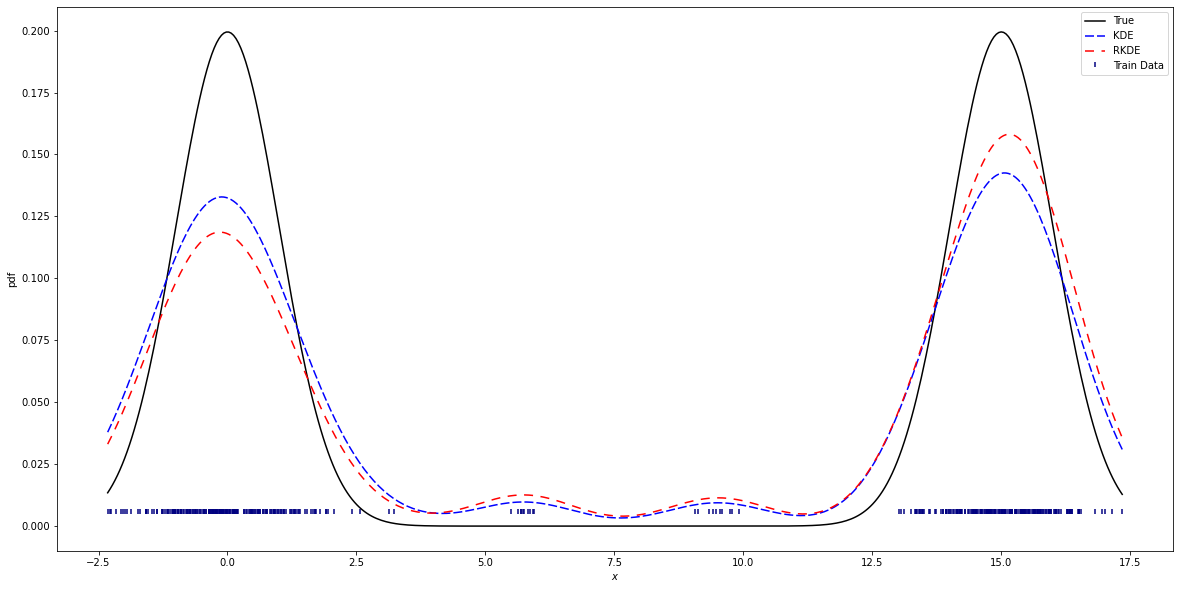

In [ ]:
new_X = np.random.choice(X,n_samples_final,p=new_weights)
X_rkde = kernel_density_function_for_rkde(bins,new_X,new_weights,windows)
##### PLOTING ##########
plt.xlabel("$x$")
plt.ylabel("pdf")

plt.scatter(X,[.005] * len(X), color='navy', s=30, marker=2, label="Train Data")
#plt.scatter(outliers,[.005] * len(outliers), color='red', s=20, marker='x', label="Outliers")

plt.plot(bins, .5 * pdf(mu1,sigma1,bins)+ .5 * pdf(mu2,sigma2,bins), color='black', label="True")
#plt.plot(bins, pdf(mu2,sigma2,bins), color='black')

plt.plot(bins, X_kde, color='blue', label="KDE", dashes=[6,2])
plt.plot(bins, X_rkde, color='red', label="RKDE", dashes=[6,5])
plt.legend()
plt.show()